<a href="https://colab.research.google.com/github/Polisetty-Cyril/HealthGPT/blob/master/Comprehension.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
!pip install torch torchvision transformers datasets accelerate pillow

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import (
    CLIPProcessor,
    CLIPVisionModel,
    AutoTokenizer,
    AutoModelForCausalLM
)
from datasets import load_dataset
from PIL import Image
import torch.nn as nn


In [ ]:
from datasets import load_dataset

dataset = load_dataset("flaviagiammarino/vqa-rad")
print(dataset)


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/train-00000-of-00001-eb8844602202be(…):   0%|          | 0.00/24.2M [00:00<?, ?B/s]

data/test-00000-of-00001-e5bc3d208bb4dee(…):   0%|          | 0.00/10.3M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1793 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/451 [00:00<?, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 1793
    })
    test: Dataset({
        features: ['image', 'question', 'answer'],
        num_rows: 451
    })
})


In [ ]:


# llm_name = "tiiuae/falcon-rw-1b"

# tokenizer = AutoTokenizer.from_pretrained(llm_name)
# model = AutoModelForCausalLM.from_pretrained(llm_name)

# # ✅ Fix padding issue
# tokenizer.pad_token = tokenizer.eos_token
# tokenizer.pad_token_id = tokenizer.eos_token_id

# model.resize_token_embeddings(len(tokenizer))


# llm_name = "distilgpt2"
# tokenizer = AutoTokenizer.from_pretrained(llm_name)

# # ✅ ADD THIS LINE RIGHT HERE
# tokenizer.pad_token = tokenizer.eos_token   # <-- This prevents the ValueError you got

# language_model = AutoModelForCausalLM.from_pretrained(llm_name)


In [ ]:
from transformers import CLIPVisionModel, CLIPProcessor, AutoTokenizer, AutoModelForCausalLM

vision_model = CLIPVisionModel.from_pretrained("openai/clip-vit-base-patch16")
vision_processor = CLIPProcessor.from_pretrained("openai/clip-vit-base-patch16")

# llm_name = "microsoft/phi-3-mini-4k-instruct"
llm_name = "distilgpt2"
tokenizer = AutoTokenizer.from_pretrained(llm_name)
language_model = AutoModelForCausalLM.from_pretrained(llm_name)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/353M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

In [ ]:
class ImageToTextModel(nn.Module):
    def __init__(self, vision_model, language_model, hidden_dim=768):
        super().__init__()
        self.vision_model = vision_model
        self.language_model = language_model
        self.projection = nn.Linear(vision_model.config.hidden_size, hidden_dim)

    def forward(self, pixel_values, input_ids, attention_mask, labels=None):
        # Extract image embeddings
        vision_outputs = self.vision_model(pixel_values)
        image_embeds = vision_outputs.last_hidden_state.mean(dim=1)

        # Project image embeddings
        projected_image = self.projection(image_embeds).unsqueeze(1)

        # Combine image + text embeddings
        inputs_embeds = torch.cat(
            [projected_image, self.language_model.get_input_embeddings()(input_ids)],
            dim=1
        )

        # Adjust attention mask to include image token
        extended_attention_mask = torch.cat(
            [torch.ones((attention_mask.size(0), 1), device=attention_mask.device), attention_mask],
            dim=1
        )

        # If labels exist, pad them to match new input length (image + text)
        if labels is not None:
            pad_token_id = -100  # ignore index for loss
            labels = torch.cat(
                [torch.full((labels.size(0), 1), pad_token_id, device=labels.device), labels],
                dim=1
            )

        # Forward through the language model
        outputs = self.language_model(
            inputs_embeds=inputs_embeds,
            attention_mask=extended_attention_mask,
            labels=labels
        )

        return outputs


In [ ]:
def preprocess_function(examples):
    # 1. Process the image
    processed_image = vision_processor(images=examples["image"], return_tensors="pt")
    pixel_values = processed_image["pixel_values"].squeeze(0)

    # 2. Set up prompt and full text
    question = examples["question"]
    answer = examples["answer"]

    # This is the format the model must learn
    prompt = f"Question: {question}\nAnswer:"

    # Full text with space before answer (tokenizer will add EOS automatically)
    full_text = f"{prompt} {answer}"

    # 3. Tokenize the *full text*
    # We use a longer max_length to accommodate both prompt and answer
    text_inputs = tokenizer(
        full_text,
        padding="max_length",
        truncation=True,
        max_length=256,  # Increased from 128
        return_tensors="pt",
        add_special_tokens=True  # Explicitly set (will add BOS/EOS)
    )

    input_ids = text_inputs["input_ids"].squeeze(0)
    attention_mask = text_inputs["attention_mask"].squeeze(0)

    # 4. Create labels: a copy of input_ids
    labels = input_ids.clone()

    # 5. Mask out the prompt tokens in the labels
    # We need to find where the prompt ends and the answer begins.
    # We tokenize *just* the prompt WITH THE SPACE to match full_text tokenization
    prompt_with_space = f"{prompt} "  # Include the space to match full_text
    prompt_inputs = tokenizer(prompt_with_space, return_tensors="pt", add_special_tokens=True)

    # The length includes everything up to (but not including) the first answer token
    prompt_len = prompt_inputs["input_ids"].shape[1]

    # Mask all tokens *up to* the end of the prompt.
    # The model will not calculate loss for these tokens.
    labels[:prompt_len] = -100

    # ✅ CRITICAL FIX: Mask padding tokens with -100
    # Without this, the model will compute loss on padding, corrupting training
    labels[labels == tokenizer.pad_token_id] = -100

    return {
        "pixel_values": pixel_values,
        "input_ids": input_ids,
        "attention_mask": attention_mask,
        "labels": labels
    }


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(processed_dataset, batch_size=1, shuffle=True)


In [ ]:
sample = processed_dataset[0]
print(type(sample["pixel_values"]), sample["pixel_values"].shape)


<class 'torch.Tensor'> torch.Size([3, 224, 224])


In [ ]:
model = ImageToTextModel(vision_model, language_model)
optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5)
model.train()

for epoch in range(2):
    for step, batch in enumerate(train_loader):
        optimizer.zero_grad()
        outputs = model(
            pixel_values=batch["pixel_values"],
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"],
            labels=batch["labels"]
        )
        loss = outputs.loss
        loss.backward()
        optimizer.step()

        if step % 10 == 0:  # print every 10 batches
            print(f"Epoch {epoch+1} | Step {step} | Loss: {loss.item():.4f}")


# for epoch in range(3):  # small demo run
#     for batch in train_loader:
#         optimizer.zero_grad()
#         outputs = model(
#             pixel_values=batch["pixel_values"],
#             input_ids=batch["input_ids"],
#             attention_mask=batch["attention_mask"],
#             labels=batch["labels"]
#         )
#         loss = outputs.loss
#         loss.backward()
#         optimizer.step()
#         print(f"Loss: {loss.item():.4f}")

# for step, batch in enumerate(train_loader):
#     with torch.no_grad():  # disables gradient computation
#         outputs = model(
#             pixel_values=batch["pixel_values"],
#             input_ids=batch["input_ids"],
#             attention_mask=batch["attention_mask"],
#             labels=batch["labels"]
#         )
#     print(f"Step {step} | Loss: {outputs.loss.item():.4f}")
#     if step > 1000:
#         break



Epoch 1 | Step 0 | Loss: 1.1140
Epoch 1 | Step 10 | Loss: 0.2260
Epoch 1 | Step 20 | Loss: 0.0632
Epoch 1 | Step 30 | Loss: 0.0993
Epoch 1 | Step 40 | Loss: 0.0493
Epoch 1 | Step 50 | Loss: 0.0277
Epoch 1 | Step 60 | Loss: 0.1738
Epoch 1 | Step 70 | Loss: 0.4390
Epoch 1 | Step 80 | Loss: 0.0392
Epoch 1 | Step 90 | Loss: 0.0488
Epoch 1 | Step 100 | Loss: 0.0212
Epoch 1 | Step 110 | Loss: 0.0406
Epoch 1 | Step 120 | Loss: 0.0828
Epoch 1 | Step 130 | Loss: 0.0082
Epoch 1 | Step 140 | Loss: 0.1514
Epoch 1 | Step 150 | Loss: 0.1686
Epoch 1 | Step 160 | Loss: 0.0875
Epoch 1 | Step 170 | Loss: 0.7830
Epoch 1 | Step 180 | Loss: 0.1972
Epoch 1 | Step 190 | Loss: 0.0536
Epoch 1 | Step 200 | Loss: 0.0264
Epoch 1 | Step 210 | Loss: 0.0491
Epoch 1 | Step 220 | Loss: 0.1577
Epoch 1 | Step 230 | Loss: 0.2402
Epoch 1 | Step 240 | Loss: 0.0496
Epoch 1 | Step 250 | Loss: 0.1915
Epoch 1 | Step 260 | Loss: 0.0149
Epoch 1 | Step 270 | Loss: 0.0249
Epoch 1 | Step 280 | Loss: 0.0249
Epoch 1 | Step 290 | Loss

In [ ]:
model.eval()

test_example = dataset["test"][0]
image = test_example["image"].convert("RGB")
question = test_example["question"]

inputs = tokenizer(f"Question: {question}\nAnswer:", return_tensors="pt")
pixel_values = vision_processor(images=image, return_tensors="pt")["pixel_values"]

with torch.no_grad():
    vision_out = model.vision_model(pixel_values)
    image_embeds = model.projection(vision_out.last_hidden_state.mean(dim=1)).unsqueeze(1)
    inputs_embeds = torch.cat([image_embeds, model.language_model.get_input_embeddings()(inputs["input_ids"])], dim=1)
    generated_ids = model.language_model.generate(inputs_embeds=inputs_embeds, max_length=50)
    print(tokenizer.decode(generated_ids[0], skip_special_tokens=True))


The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.


In [ ]:
def predict(image, question):
    image = image.convert("RGB")
    pixel_values = vision_processor(images=image, return_tensors="pt")["pixel_values"]
    inputs = tokenizer(f"Question: {question}\nAnswer:", return_tensors="pt")

    with torch.no_grad():
        vision_out = model.vision_model(pixel_values)
        image_embeds = model.projection(vision_out.last_hidden_state.mean(dim=1)).unsqueeze(1)
        inputs_embeds = torch.cat([
            image_embeds,
            model.language_model.get_input_embeddings()(inputs["input_ids"])
        ], dim=1)
        generated_ids = model.language_model.generate(inputs_embeds=inputs_embeds, max_length=50)

    answer = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
    return answer


In [ ]:
import gradio as gr

demo = gr.Interface(
    fn=predict,
    inputs=[
        gr.Image(type="pil", label="Upload Medical Image"),
        gr.Textbox(label="Ask a medical question")
    ],
    outputs="text",
    title="HealthGPT - Medical Image Comprehension",
    description="Upload an image and ask a question about it."
)

demo.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0383f139bb0a62ed79.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


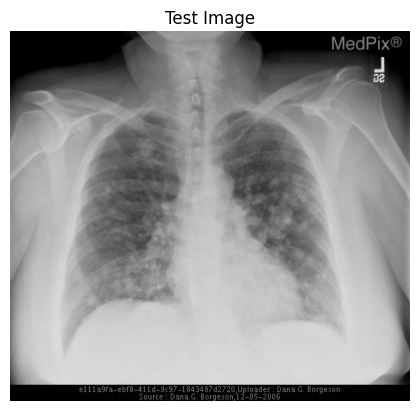

🧠 Random Test Example: 188
❓ Question: can a patient with a metal implant get a cxr?
💬 Model Answer: 


In [ ]:
import random, torch, matplotlib.pyplot as plt

model.eval()
tokenizer.pad_token = tokenizer.eos_token

# pick a random test example
idx = random.randint(0, len(dataset["test"]) - 1)
example = dataset["test"][idx]
image = example["image"].convert("RGB")
question = example["question"]

# encode
inputs = tokenizer(f"Q: {question}\nA:", return_tensors="pt")
pixel_values = vision_processor(images=image, return_tensors="pt")["pixel_values"]

# generate
with torch.no_grad():
    vision_out = model.vision_model(pixel_values)
    image_embeds = model.projection(vision_out.last_hidden_state.mean(dim=1)).unsqueeze(1)
    inputs_embeds = torch.cat(
        [image_embeds, model.language_model.get_input_embeddings()(inputs["input_ids"])],
        dim=1
    )
    generated_ids = model.language_model.generate(
    inputs_embeds=inputs_embeds,
    attention_mask=torch.ones(inputs_embeds.shape[:2], dtype=torch.long),
    max_length=100,                # was 50
    pad_token_id=tokenizer.eos_token_id,
    do_sample=True,                # allows creative output
    temperature=0.8,               # randomness
    top_p=0.9                      # nucleus sampling
)


answer = tokenizer.decode(generated_ids[0], skip_special_tokens=True)

# visualize and print
plt.imshow(image)
plt.axis("off")
plt.title("Test Image")
plt.show()

print(f"🧠 Random Test Example: {idx}")
print(f"❓ Question: {question}")
print(f"💬 Model Answer: {answer.strip()}")
